In [3]:
# Begas Library
#import s3fs
import warnings
import time
import re
import pandas as pd
import numpy as np
import os
import itertools
import multiprocessing
import pickle
import tensorflow as tf
import matplotlib
import matplotlib.pylab as plt
from sklearn import tree
from tensorflow import keras
from functools import partial
from itertools import repeat
from datetime import datetime
#from sagemaker import get_execution_role
#from dataHandling import dataHandling
#from batchTools import batchTools
#from gruDataReshaper import gruDataReshaper

In [4]:
import keras
import tensorflow as tf

from IPython.display import display
import PIL 

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1500835471381885562
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6614766059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11642370374397029530
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [8]:
print(tf.__version__)

2.0.0


In [9]:
df = pd.read_csv('original_full_data.csv', index_col = 0)

In [10]:
mmdf = pd.read_csv('bloomberg_map_index_20200130.csv', index_col = 0)

In [11]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df = df.loc[9132 :, :]

In [13]:
len(df)

5051

In [14]:
df.reset_index(inplace = True, drop = True)

In [15]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = self.df[target_column].shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0)

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [16]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [17]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [18]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [19]:
df.isna().sum().sum()

0

In [20]:
cla = Builder(df, mmdf, 1)

In [21]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [22]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [23]:
df.reset_index(inplace = True)

In [24]:
TRAIN_SPLIT = 4000 # 3000부터 대강 쪼개면 될듯

In [25]:
tf.random.set_seed(13)

In [26]:
def create_time_steps(length): # 이전 len 5 4 3 2 1 이렇게 스텝 생성하는 function
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']

    time_steps = create_time_steps(plot_data[0].shape[0]) # 들어가는 plot_data 는 x_train_uni , 20개 하고 label y_train_uni 하나니까 그래프가 저렇게 

    if delta: # delta는 y_train 
        future = delta # 확인 결과 True난 1이거나 값이 있으면 실행 False, 0 , None인 경우 미 실행 delta가 값이 있으면 그걸로 받는것이다 (1이상))
    else :
        future = 0



    plt.title(title) # 이건 걍 title
    for i, x in enumerate(plot_data): # plot data 순회 -> 마지막 깨달음 아 시박 x y가 둘 다 들어갔으니 당연히 0, 1이지 시발

        if i: # 0이면 ? plot_data [0] 에 대해서만 이 그림을 그리고 처음에 밑그림을 그릴 필요가 있어서 이렇게 짠거인듯. 0 False None 빼고 다 출력
                        
            plt.plot(future, plot_data[i], marker[i], markersize = 5, # else를 보고 이걸 보면.. 처음에 전체 데이터를 가지고 그림을 그린 다음 그냥 마지막 것만 실행하며 덧씌우고
                     # future를 가지고 True Future 점을 하나 찍는 형태가 된거임. 
                     label = labels[i]) # label 의 1이 적용이 된건데? marker의 1이 적용이 되고, plot
            
        else: # 0 False None 인경우 인듯. 0인 경우 그림을 그림 time_steps plot_data[i] (x_train_uni0길이만큼 정수 : 0 ~ 20) flatten을 하는 이유는 그냥 한줄로 넣으려고. np는그게도나봄. 
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i]) # label도 label의 0~ 20번째 근데 라벨값은 하나아냐?  아 0이니까. 
    # 점을 찍었다면 x축은 어디가 되는건가? 아 알겠군 -> time step이 필요했던건 real값과 prediction값을 다른 선상에 두기 위해서였다. 
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')

    return plt

In [28]:
features_considered = ['SKhynix_change', 'Philadelphia_change', 'Micron_change', 'MediaTek_change', 'USDollarIndex_close', 'FRNTTNETIndex', 'Intel_product', 'USD_KRW_change', 'CPUPXCHGIndex', 'KOBONTLIndex', 'RSTAMOMIndex', 'KOEXPTIYIndex', 'KOCPIMOMIndex', 'Dell_close', 'Dell_volume', 'GPGSTOC%Index', 'SKLIOTARIndex', 'Nvidia_volume', 'SKCIMOMIndex', 'KOCGCGYIndex', 'KOECPRCYIndex', 'LEIBPIndex', 'AMD_change', 'JOLTSEPSIndex', 'HPE_close', 'Sumco_change', 'KOGFBALIndex', 'CNFREXPYIndex', 'TokyoElectron_close', 'EUR_KRW_close', 'KOBPFINIndex', 'Amazon_change', 'UMC_product', 'KOECGVTYIndex', 'KOBPCAIndex', 'KOECIMPYIndex', 'NAPMNMIIndex', 'USWHTOTIndex', 'Amazon_volume', 'KOECFCSYIndex', 'Google_product', 'KOFDITYIndex', 'KOQEEYOYIndex', 'TokyoElectron_volume', 'CNGDPYOYIndex', 'MBRXYOYWIndex', 'ShinEtsuChemical_volume', 'USTBEXPYIndex', 'AppliedMaterials_product', 'QCOM_product', 'SKhynix_product', 'UMC_volume', 'APPLE_product', 'KOECSIMQIndex', 'SKLICPYIndex', 'SKLICONEIndex', 'LEIMNOIndex', 'SAARDTOTIndex', 'KOBPCBIndex', 'USHEYOYIndex', 'USEMNCHGIndex', 'MGT2MAIndex', 'KOPPIMOMIndex', 'KOIVCONYIndex', 'Intel_volume', 'g16', 'AMD_product', 'KOEXTOTIndex', 'KOFETOTIndex', 'SKLINBARIndex', 'ssd_price', 'SKLILAPIndex', 'KOCPIIndex', 'TSMC_product', 'KOPPIYOYIndex', 'Philadelphia_volume', 'APPLE_volume', 'RSTAYOYIndex', 'Micron_product', 'Micron_volume', 'PITLCHNGIndex', 'SAARTOTLIndex', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'TokyoElectron_change', 'Intel_change', 'KOWDRIndex', 'Nvidia_product', 'ShinEtsuChemical_close', 'memory_price', 'NFPTCHIndex', 'NFPPCHIndex', 'KOGDPYOYIndex', 'KOEAEPRIndex', 'USGG3MIndex', 'SKLILAIIndex']

In [29]:
target_considered = ['KRXsemiconductor_change']

In [30]:
targets = df[target_considered]
features = df[features_considered]

In [31]:
features.index = df['date']
targets.index = df['date']

In [32]:
col_name = features.columns
dataset = MinMaxScaler().fit_transform(features)# Standard
dataset = pd.DataFrame(dataset, columns = col_name)

In [33]:
X_data = dataset

In [34]:
y_target = targets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [36]:
X_train = X_train.values

In [37]:
y_train = y_train.values

In [38]:
X_test = X_test.values

In [39]:
y_test = y_test.values

In [40]:
type(X_train)

numpy.ndarray

In [41]:
dataset.shape

(5051, 98)

In [42]:
X_train.shape

(4040, 98)

In [43]:
X_train_t = X_train.reshape(X_train.shape[0], 98, 1)

In [44]:
X_train_t.shape

(4040, 98, 1)

In [45]:
X_test_t = X_test.reshape(X_test.shape[0], 98, 1)

In [46]:
X_train_t.shape, X_test_t.shape

((4040, 98, 1), (1011, 98, 1))

In [46]:
'''
def modelgen(nTimeSteps, nFeature):
    layer_input = keras.Input(shape=(nTimeSteps, nFeature), name='input')
    layer_state = keras.layers.CuDNNGRU(units=100, return_state=True, name='gru_cell_0')(layer_input)[1]
    layer_gru = keras.layers.CuDNNGRU(units=100, return_sequences=True, name='gru_cell_1')(layer_input, initial_state=layer_state)
    layer_gru = keras.layers.CuDNNGRU(units=100, return_sequences=True, name='gru_cell_2')(layer_gru)
    layer_output = keras.layers.TimeDistributed(
        keras.layers.Dense(units=1, activation='linear',
                          kernel_regularizer=keras.regularizers.l2(l=0.3),
                          kernel_initializer=tf.keras.initializers.Orthogonal(seed=925)), name='output')(layer_gru) 
    gru_model = keras.Model(layer_input, layer_output)
    gru_model.compile(loss=customLoss, optimizer=keras.optimizers.Adam())
    return gru_model
'''

"\ndef modelgen(nTimeSteps, nFeature):\n    layer_input = keras.Input(shape=(nTimeSteps, nFeature), name='input')\n    layer_state = keras.layers.CuDNNGRU(units=100, return_state=True, name='gru_cell_0')(layer_input)[1]\n    layer_gru = keras.layers.CuDNNGRU(units=100, return_sequences=True, name='gru_cell_1')(layer_input, initial_state=layer_state)\n    layer_gru = keras.layers.CuDNNGRU(units=100, return_sequences=True, name='gru_cell_2')(layer_gru)\n    layer_output = keras.layers.TimeDistributed(\n        keras.layers.Dense(units=1, activation='linear',\n                          kernel_regularizer=keras.regularizers.l2(l=0.3),\n                          kernel_initializer=tf.keras.initializers.Orthogonal(seed=925)), name='output')(layer_gru) \n    gru_model = keras.Model(layer_input, layer_output)\n    gru_model.compile(loss=customLoss, optimizer=keras.optimizers.Adam())\n    return gru_model\n"

In [47]:
# rmse custorm metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [48]:
# Begas Custom Loss Function
def customLoss(y_true, y_pred):
    mean_true = tf.math.reduce_mean(y_true)
    mean_pred = tf.math.reduce_mean(y_pred)
    
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    
    up = tf.reduce_mean(tf.math.multiply((y_true-mean_true), (y_pred-mean_pred)))
    down = std_true * std_pred
    corr = 1.0-tf.compat.v1.where(tf.math.is_nan(up/down),0.0,up/down)
    
    
    meanerr = tf.math.sqrt(tf.math.square(mean_true - mean_pred))
    mserr = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_true-y_pred)))
    signerr = 1-tf.math.reduce_mean(tf.math.multiply(tf.math.sign(y_true), tf.math.sign(y_pred)))
    
    return mserr + corr/2 + signerr/2

In [91]:

K.clear_session()

# using /gpu:0
with tf.device('/gpu:0'):
    
    # model build
    model = Sequential(name = 'KRXSemicondoctor_regressor')
    model.add(LSTM(128, input_shape = (98, 1), return_sequences = True, name = 'input'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences = True, name = 'lstm_cell_0'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences = True, name = 'lstm_cell_1'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(32, return_sequences = False, name = 'lstm_cell_2'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(1, activation = 'linear', name = 'output',
                   kernel_regularizer=keras.regularizers.l2(l=0.3)))
                   #kernel_initializer=tf.keras.initializers.Orthogonal(seed=925))) 

    #rmsprop = optimizers.rmsprop(lr = 0.01)
    adam = optimizers.Adam(lr = 0.001)
    
    # compile model
    model.compile(loss = customLoss,
                  optimizer=adam,
                  metrics=[root_mean_squared_error])
    
    # early stopping
    early_stop = EarlyStopping(monitor=customLoss, patience=10, verbose=1)
    
    # model check
    model.summary()
    
    h = model.fit(X_train_t, y_train, epochs=100,
          batch_size=100, verbose=1, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (LSTM)                 (None, 98, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 128)           512       
_________________________________________________________________
lstm_cell_0 (LSTM)           (None, 98, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 64)            256       
_________________________________________________________________
lstm_cell_1 (LSTM)           (None, 98, 64)           

In [48]:
K.clear_session()

# using /gpu:0
with tf.device('/gpu:0'):
    
    # model build
    model = Sequential(name = 'KRXSemicondoctor_regressor')
    model.add(LSTM(256, input_shape = (98, 1), return_sequences = True, name = 'input'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(LSTM(128, return_sequences = True, name = 'lstm_cell_0'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences = True, name = 'lstm_cell_1'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(LSTM(32, return_sequences = False, name = 'lstm_cell_2'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(1, activation = 'linear', name = 'output',
                   kernel_regularizer=keras.regularizers.l2(l=0.3)))
                   #kernel_initializer=tf.keras.initializers.Orthogonal(seed=925))) 

    #rmsprop = optimizers.rmsprop(lr = 0.01)
    adam = optimizers.Adam(lr = 0.0001)
    
    # compile model
    model.compile(loss = customLoss,
                  optimizer=adam,
                  metrics=[root_mean_squared_error])
    
    # early stopping
    early_stop = EarlyStopping(monitor='mse', patience=20, verbose=1)
    
    # model check
    model.summary()
    
    h = model.fit(X_train_t, y_train, epochs=1000,
          batch_size=20, verbose=1, callbacks=[early_stop])

Model: "KRXSemicondoctor_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (LSTM)                 (None, 98, 256)           264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 256)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 256)           1024      
_________________________________________________________________
lstm_cell_0 (LSTM)           (None, 98, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 98, 128)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 128)           512       
_________________________________________________________________
lstm_cell_1 (LSTM)           (None, 98, 

C:\Users\mokpolar\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `mse` which is not available. Available metrics are: loss,root_mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4040/4040 [==============================] - 53s 13ms/step - loss: 3.6481 - root_mean_squared_error: 1.7236
Epoch 3/1000
4040/4040 [==============================] - 53s 13ms/step - loss: 3.6696 - root_mean_squared_error: 1.7173
Epoch 4/1000
4040/4040 [==============================] - 53s 13ms/step - loss: 3.5841 - root_mean_squared_error: 1.6913
Epoch 5/1000
4040/4040 [==============================] - 53s 13ms/step - loss: 3.4986 - root_mean_squared_error: 1.6450
Epoch 6/1000
4040/4040 [==============================] - 54s 13ms/step - loss: 3.5732 - root_mean_squared_error: 1.6688
Epoch 7/1000
4040/4040 [==============================] - 54s 13ms/step - loss: 3.4101 - root_mean_squared_error: 1.6302
Epoch 8/1000
4040/4040 [==============================] - 53s 13ms/step - loss: 3.3741 - root_mean_squared_error: 1.6081
Epoch 9/1000
4040/4040 [==============================] - 53s 13ms/step - loss: 3.3163 - root_mean_squared_error: 1.5889
Epoch 10/1000
4040/4040 [====================

In [50]:
import pickle
with open('model_20200308_1_pickle', 'wb') as file_pi:
    pickle.dump(h.history, file_pi)

In [64]:
model.save('model_20200308_h5_model.h5')

In [63]:
from keras.models import load_model

model.save('model.h5')

## 모델 아키텍처 따로 저장
# 모델 아키텍처를 json 형식으로 저장
#json_string = model.to_json()
# json 파일에서 모델 아키텍처 재구성
#model = model_from_json(json_string)
## Weights 따로 저장
#model.save_weights()

NameError: name 'model_from_json' is not defined

In [ ]:
#model = load_model('model/multi_task/try.h5', custom_objects={'loss_max': loss_max})


In [49]:
from keras.models import load_model
# compile전에 save를 했어야 했네. 근데 compile을 이미 했으면 어떡하냐;
model2 = load_model('model_20200308_h5_model.h5', custom_objects={'customLoss': customLoss, 'root_mean_squared_error': root_mean_squared_error})

In [ ]:
y_pred = model2.predict(X_test_t)


In [50]:
x_pred = model2.predict(X_train_t)

InternalError:  Blas GEMM launch failed : a.shape=(32, 256), b.shape=(256, 1024), m=32, n=1024, k=256
	 [[{{node input/while/body/_1/MatMul_1}}]] [Op:__inference_keras_scratch_graph_9917]

Function call stack:
keras_scratch_graph


In [74]:
y_pred = np.reshape(y_pred, (1011))
y_test = np.reshape(y_test, (1011))
x_pred = np.reshape(x_pred, (4040))
y_trai = np.reshape(y_train, (4040))

In [75]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.396467,-0.0065,1.5280,1.9785,0.5727,0.642998


In [76]:
metr = CustomMetric(x_pred, y_trai)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.801252,0.5713,0.9179,1.3995,0.758168,0.871921


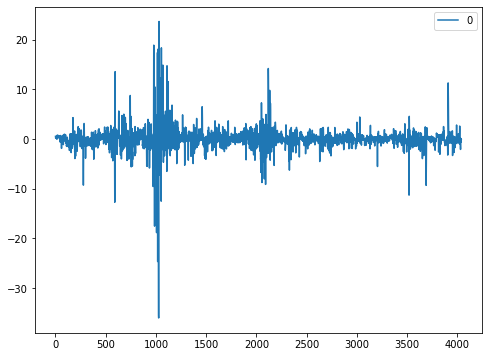

In [56]:
pd.DataFrame(model.predict(X_train_t)).plot()

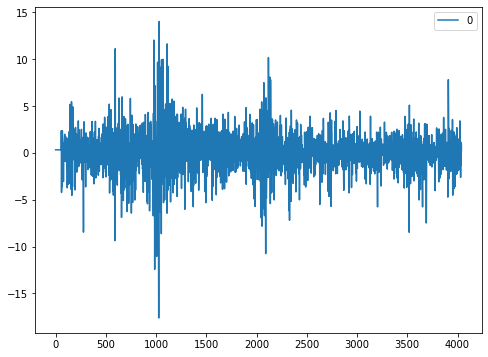

In [57]:
pd.DataFrame(y_train).plot()

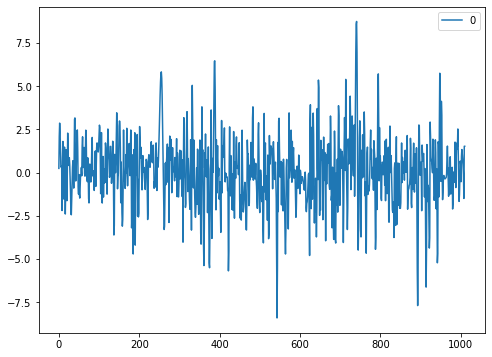

In [58]:
pd.DataFrame(y_test).plot()

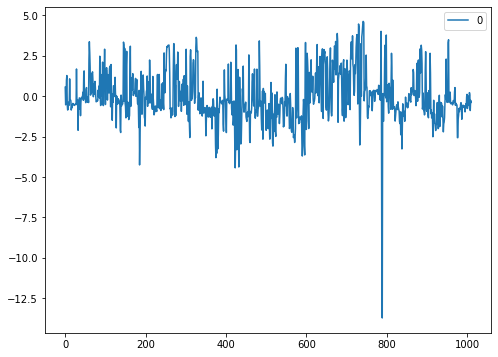

In [59]:
pd.DataFrame(y_pred).plot()

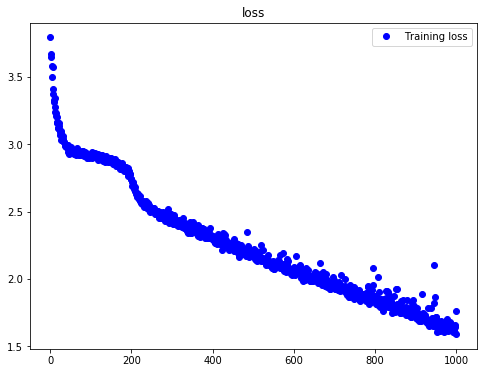

In [61]:
#mse = h.history['mse']
#val_mse = h.history['val_mse']
loss = h.history['loss']
#val_loss = h.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, mse, 'bo', label = 'Training mse')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation mse')
#plt.title('mse')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation loss')
plt.title('loss')
plt.legend()

plt.show()

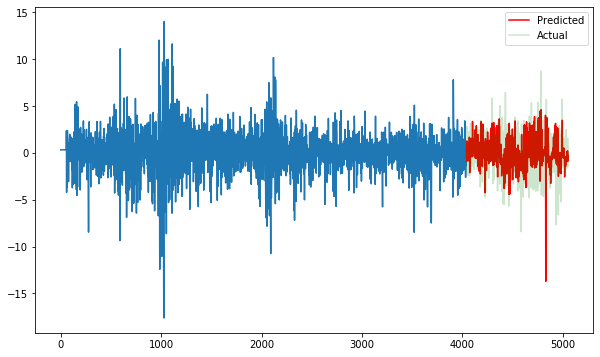

In [60]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(4040,), '-')
plt.plot(b_axis, y_pred.reshape(1011,), '-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1011,), '-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

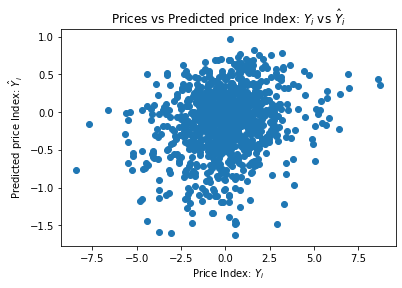

In [279]:
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")